In [60]:
# the model was trained on fixed pdf layout to extract data from randomised layout
# So much data to label for the real work though, might do feature engineering


from transformers import LayoutLMv3Tokenizer,LayoutLMv3FeatureExtractor,LayoutLMv3ForTokenClassification,AutoModelForTokenClassification,AutoProcessor
from common import *
import random

In [2]:
%%capture
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = AutoModelForTokenClassification.from_pretrained('/home/delta/vscode/dataextraction/model')
model.to(device)
model.eval()

In [63]:
def extractData(image):
    encoding = features(image)
    encoding = processor(image, encoding['words'],boxes=encoding['boxes'], return_tensors='pt')
    outputs = model(**encoding.to(device))
    outputs = [dict2label[s] for s in outputs.logits.argmax(-1).tolist()[0]]
    inputs = encoding['input_ids'][0]
    boxes = encoding['bbox'].cpu().tolist()[0]
    inputs = [processor.decode(i) for i in inputs]
    da = pd.DataFrame(columns=['inputs','outputs','boxes'])
    da['inputs'] = inputs
    da['outputs'] = outputs
    da['boxes'] = boxes
    font = ImageFont.load_default()
    draw = ImageDraw.Draw(image)
    answer = pd.DataFrame(columns=['key','value'])
    l = 0
    for n,g in da.groupby('outputs'):
        if n == 'other':
            continue
        pre = g['inputs'].values.tolist()
        pre = ''.join(pre)
        pre = pre.lstrip().rstrip()
        n = n.capitalize()
        answer.at[l,'key'] = n
        answer.at[l,'value'] = pre
        l += 1
        box = g['boxes'].values.tolist()
        color = tuple(random.choices(range(256), k=3))  
        for b in box:
            x1,y1,x2,y2 = b
            x1 = int(image.width*x1/1000)
            x2 = int(image.width*x2/1000)
            y1 = int(image.height*y1/1000)
            y2 = int(image.height*y2/1000)
            b = [x1,y1,x2,y2]
            draw.rectangle(b, outline=color, width=2)
            draw.text((b[0] + 10, b[1] - 10), n, fill='red', font=font)
    return answer, image
def generateonefakeppdf():
    from faker import Faker
    import warnings
    warnings.filterwarnings('ignore')
    from fpdf import FPDF
    import pdf2image
    fake = Faker()
    pdf = FPDF()
    pdf.add_page()
    pdf.set_font('Helvetica', size=12)
    profile = fake.profile()
    fake_data = [profile[k] for k in profile.keys()]
    fake_label = [k for k in profile.keys()]
    fake_label.append('Description')
    description = [fake.catch_phrase()]
    for p in fake.paragraphs():
        description.append(p)
    fake_data.append(description)
    shufleindex = [i for i in range(len(fake_data))]
    shufleindex = shuffle(shufleindex)
    for randomstucture in shufleindex:
        fl = fake_label[randomstucture]
        fd = fake_data[randomstucture]
        if fl != 'Description':
            pdf.cell(txt=' ',ln=1)
            pdf.cell(txt=f'{fl.capitalize()}:')
            if random.randint(0,1) == 0:
                pdf.cell(txt=' ',ln=1)
            pdf.cell(txt= f' {fd}',ln=1)
        else:
            pdf.cell(txt=' ',ln=1)
            pdf.cell(0, 10, 'Description', 0, 0, 'C')
            pdf.ln(10)
            pdf.cell(txt=' ',ln=1)
            for p in fd:
                pdf.multi_cell(align='l',txt=p,w=200,ln=1)
                pdf.cell(txt=' ',ln=1)
    pdf.output(f"fakepdf.pdf")
    image = pdf2image.convert_from_path('fakepdf.pdf')[0]
    return image 

def generatetest():
    image_ = generateonefakeppdf()
    image = image_.copy()
    e,s =extractData(image_)
    print(e)
    return s  

            key                                              value
0       Address  433 Smith StreamPort Michelefort, IN 407400872...
1      Birthday                                11-275600 1972-0802
2   Blood_group                                                 B-
3       Company                 Automated leadingedge hardwareanho
4   Description  <s> Reach officer everybody piece. Purpose car...
5           Job                                             bizorg
6      Location                (Decimal Decimal-.))http://http:///
7          Mail                                 wukyle@hotmail.com
8          Name                   Hall-Cannonin08 Benjamin Barajas
9           Sex                                                  M
10          Ssn                                           7-7.9162
11     Username                                             erlog.
12      Website                                   (''),('�� ['", '


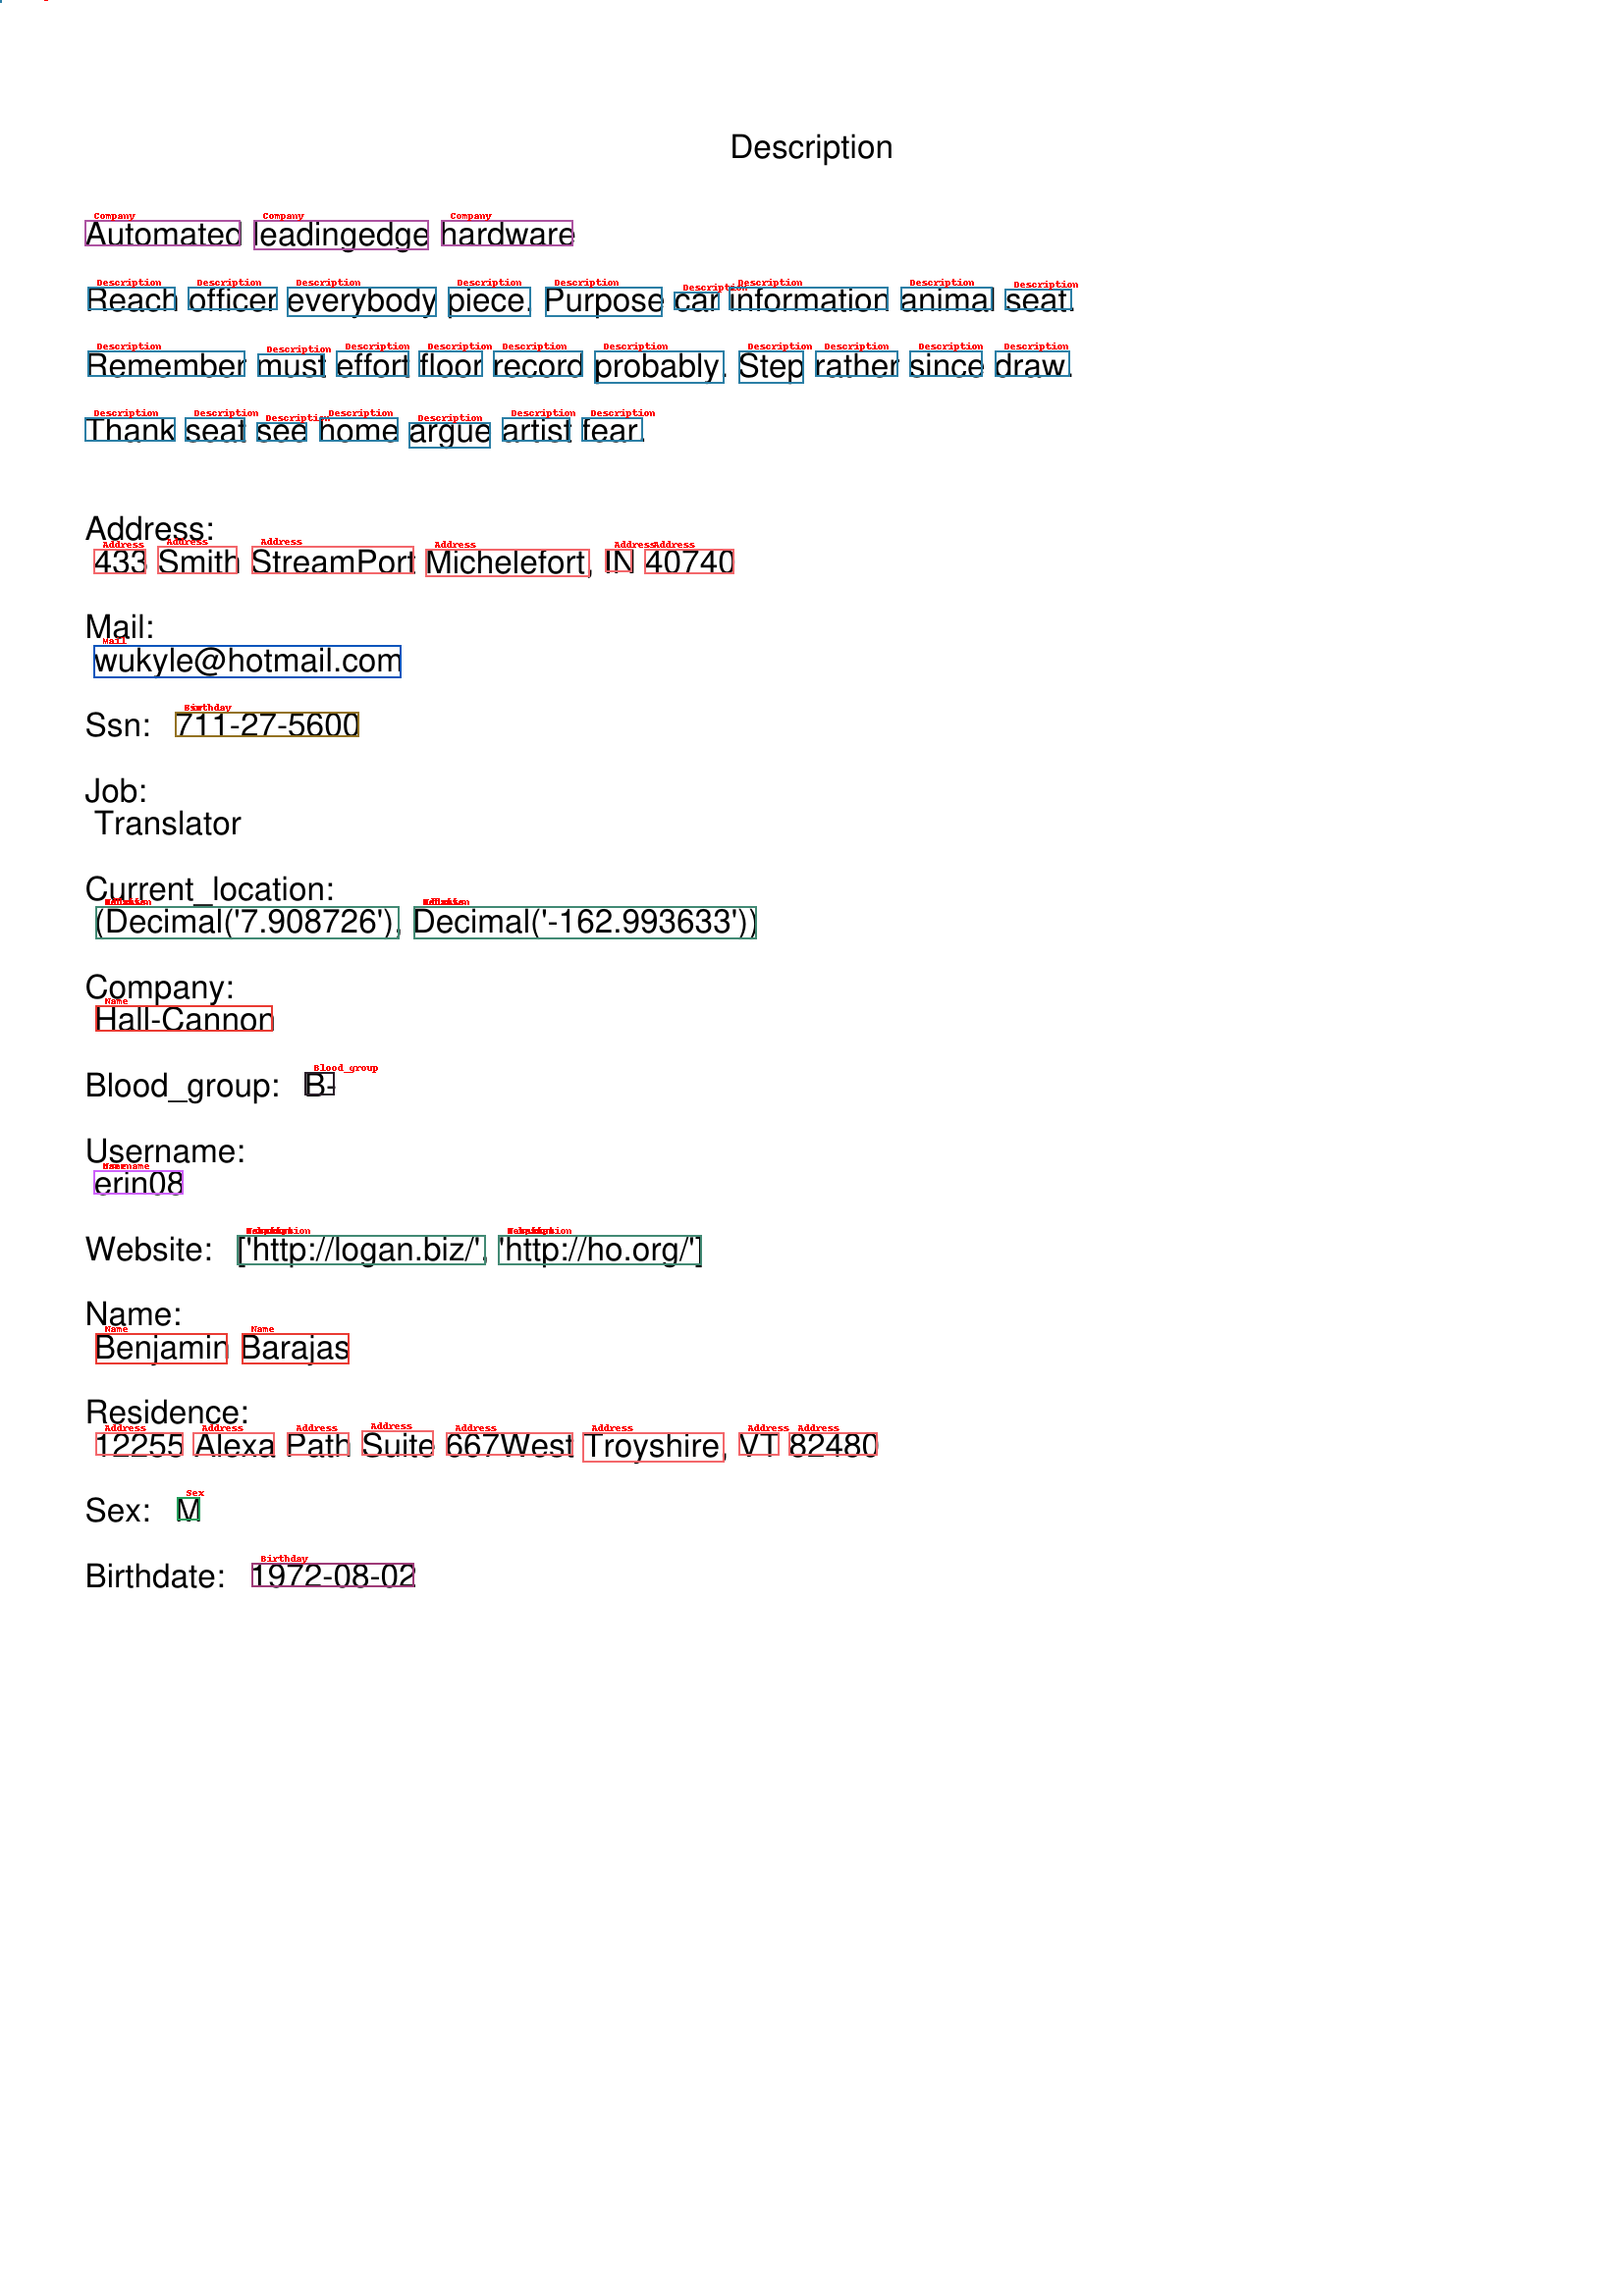

In [64]:
 generatetest()

            key                                              value
0       Address  25084 Laura Run Apt 217South Wandaville, NE 86...
1   Blood_group                                                 B-
2       Company                                                jac
3   Description  <s>. Devolved directional Internet solution Si...
4           Job                                                obs
5      Location                                       DechttpAcom/
6          Mail                                             vhill@
7          Name    Musician Edward Mills Terry, Duffy and Harrisry
8      Resident                         763 Decimal156. 10691 7'))
9           Sex                                                  M
10          Ssn                        1920-07-13 371-85-72715.134
11     Username               hotmail.comimal stephanieperwwwdunn-
12      Website                                       (''),(' [':/


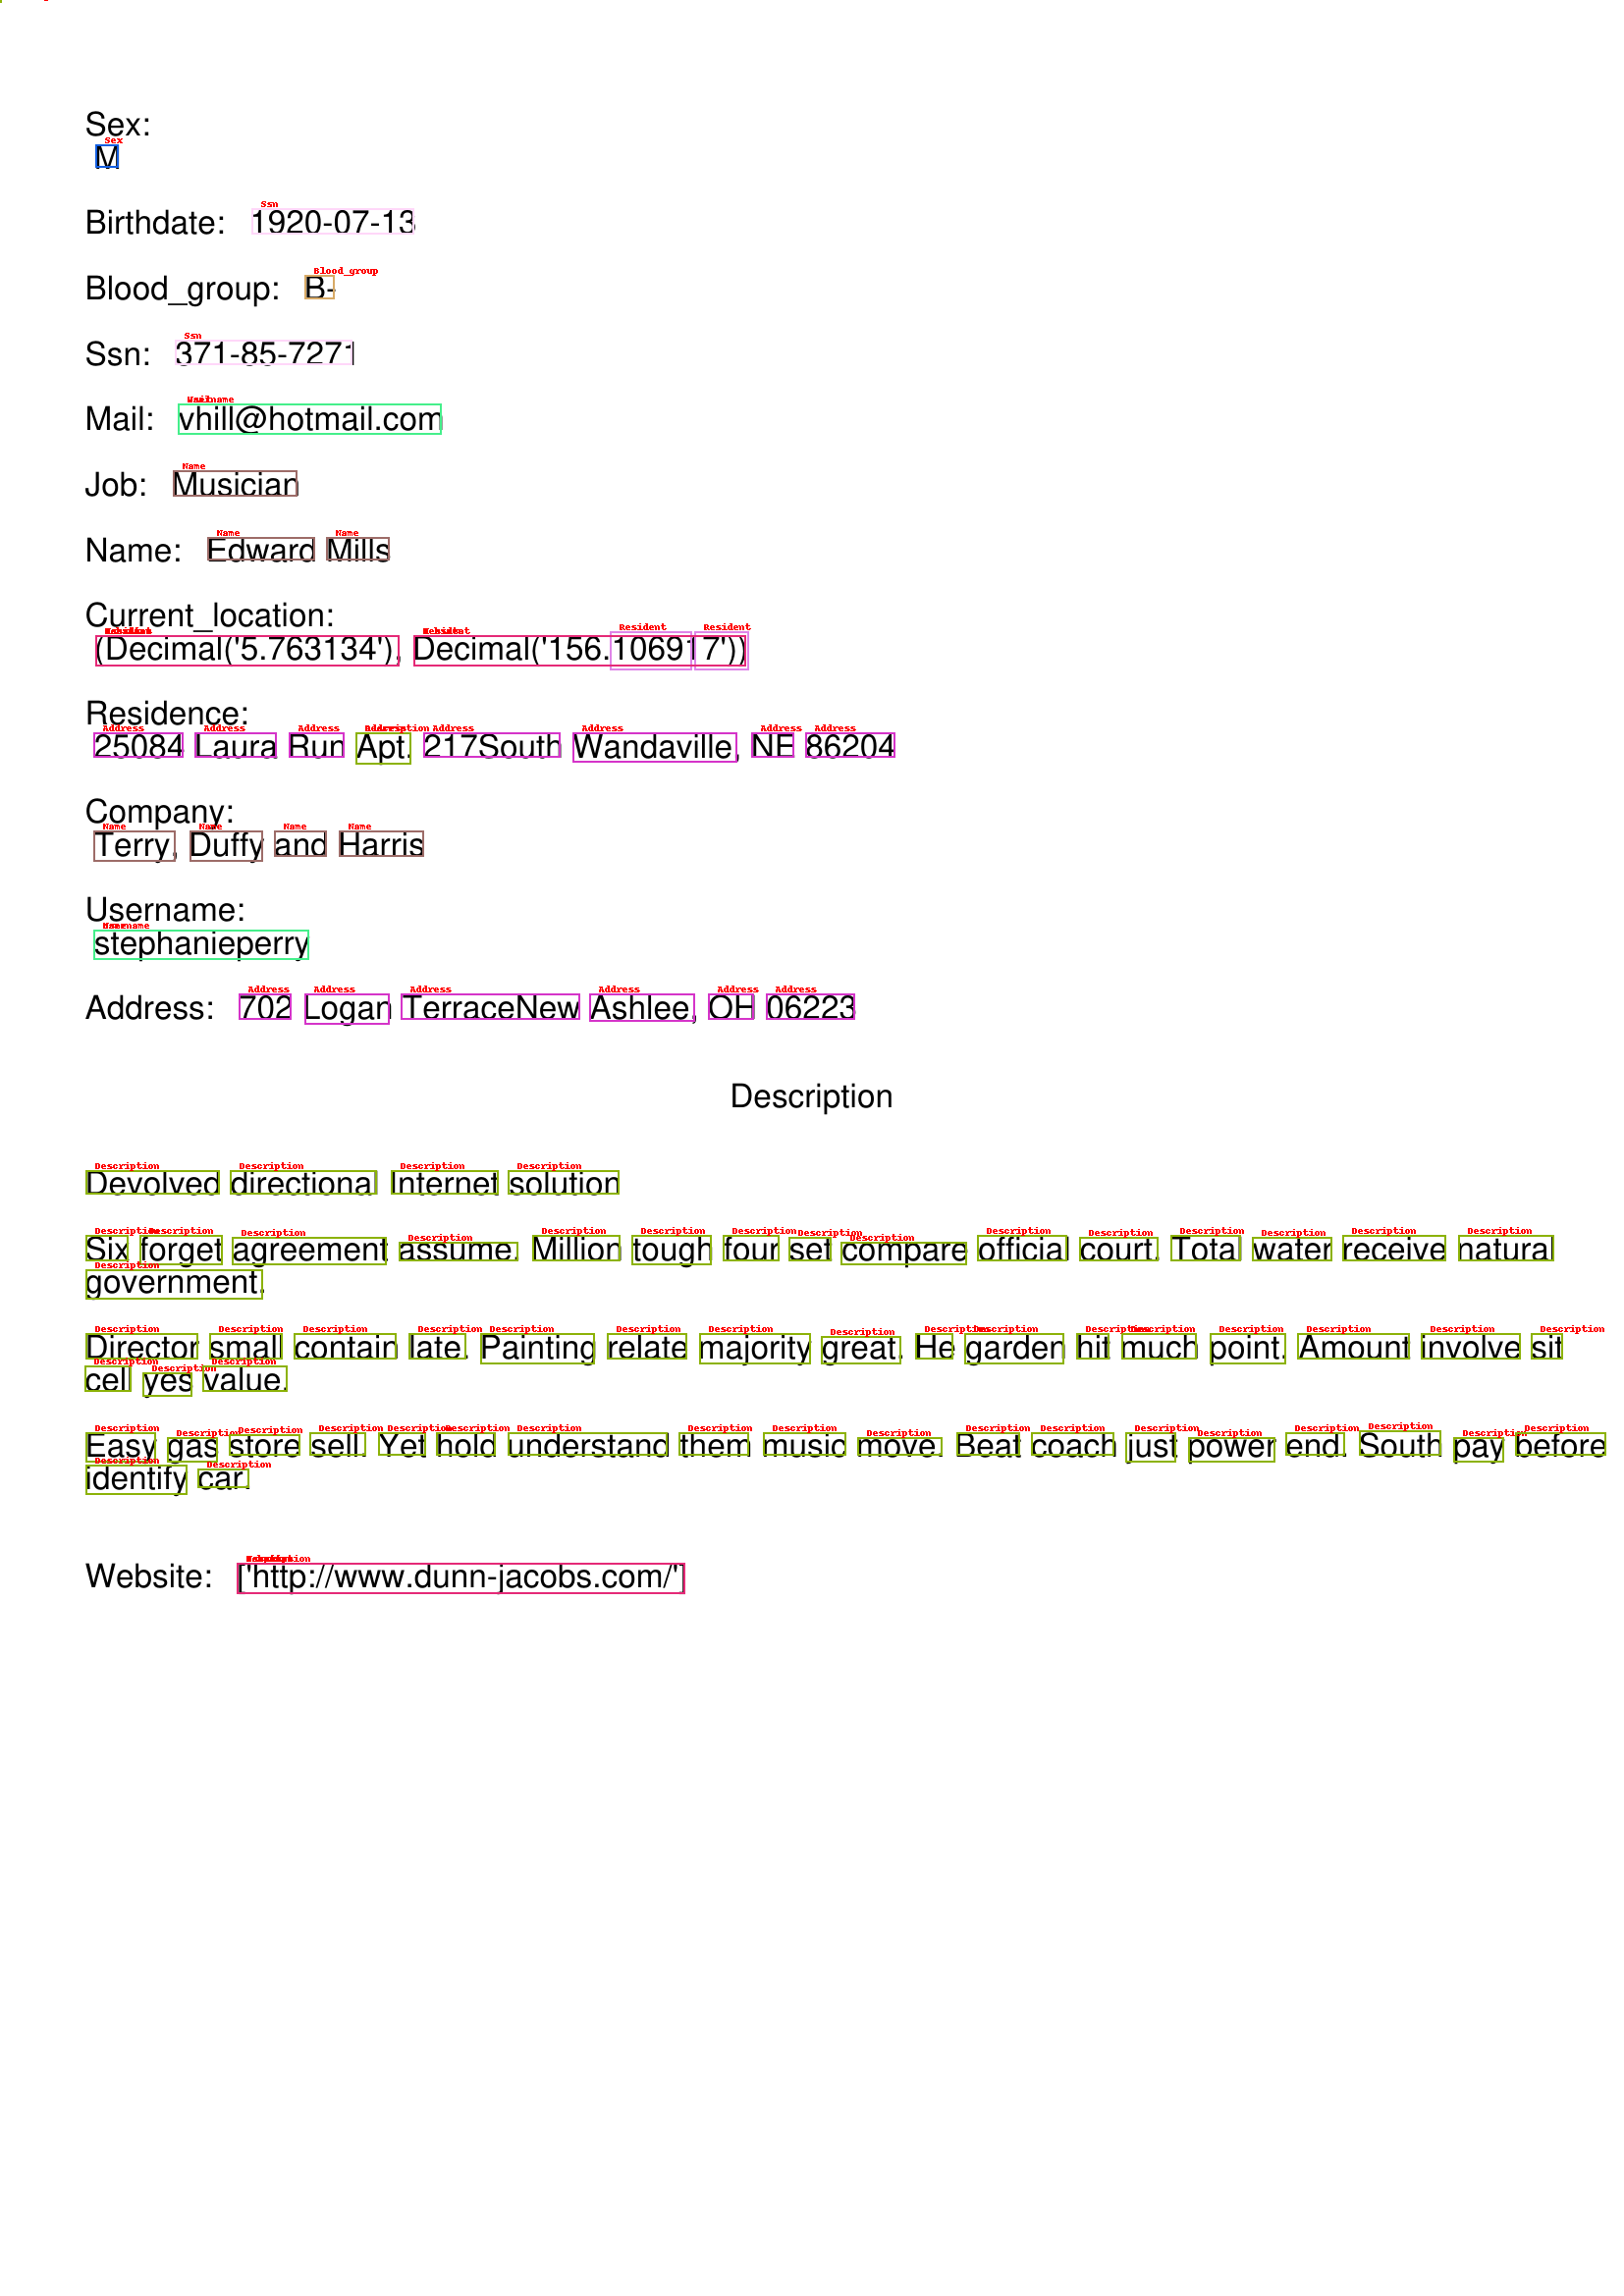

In [65]:
 generatetest()

            key                                              value
0       Address      6060 Tammy GreensMathewville, NC 902420016420
1      Birthday                                         1933-09-01
2   Blood_group                                               O+16
3       Company                                           hotmail.
4   Description  <s> Innovative context-sensitive Graphic Inter...
5           Job  comosbaker-brandt.info Call centre manager Rob...
6      Location                        (Decimal18. Decimal-68.27))
7          Mail                                    rasmussenkrist@
8          Name                      en Michael Woodward Clark Inc
9      Resident                       htt/ 2082 Katie, SD 27960107
10          Sex                                                  M
11          Ssn                                        077-83-6149
12     Username                                            kristin
13      Website                                    ['://"]('')

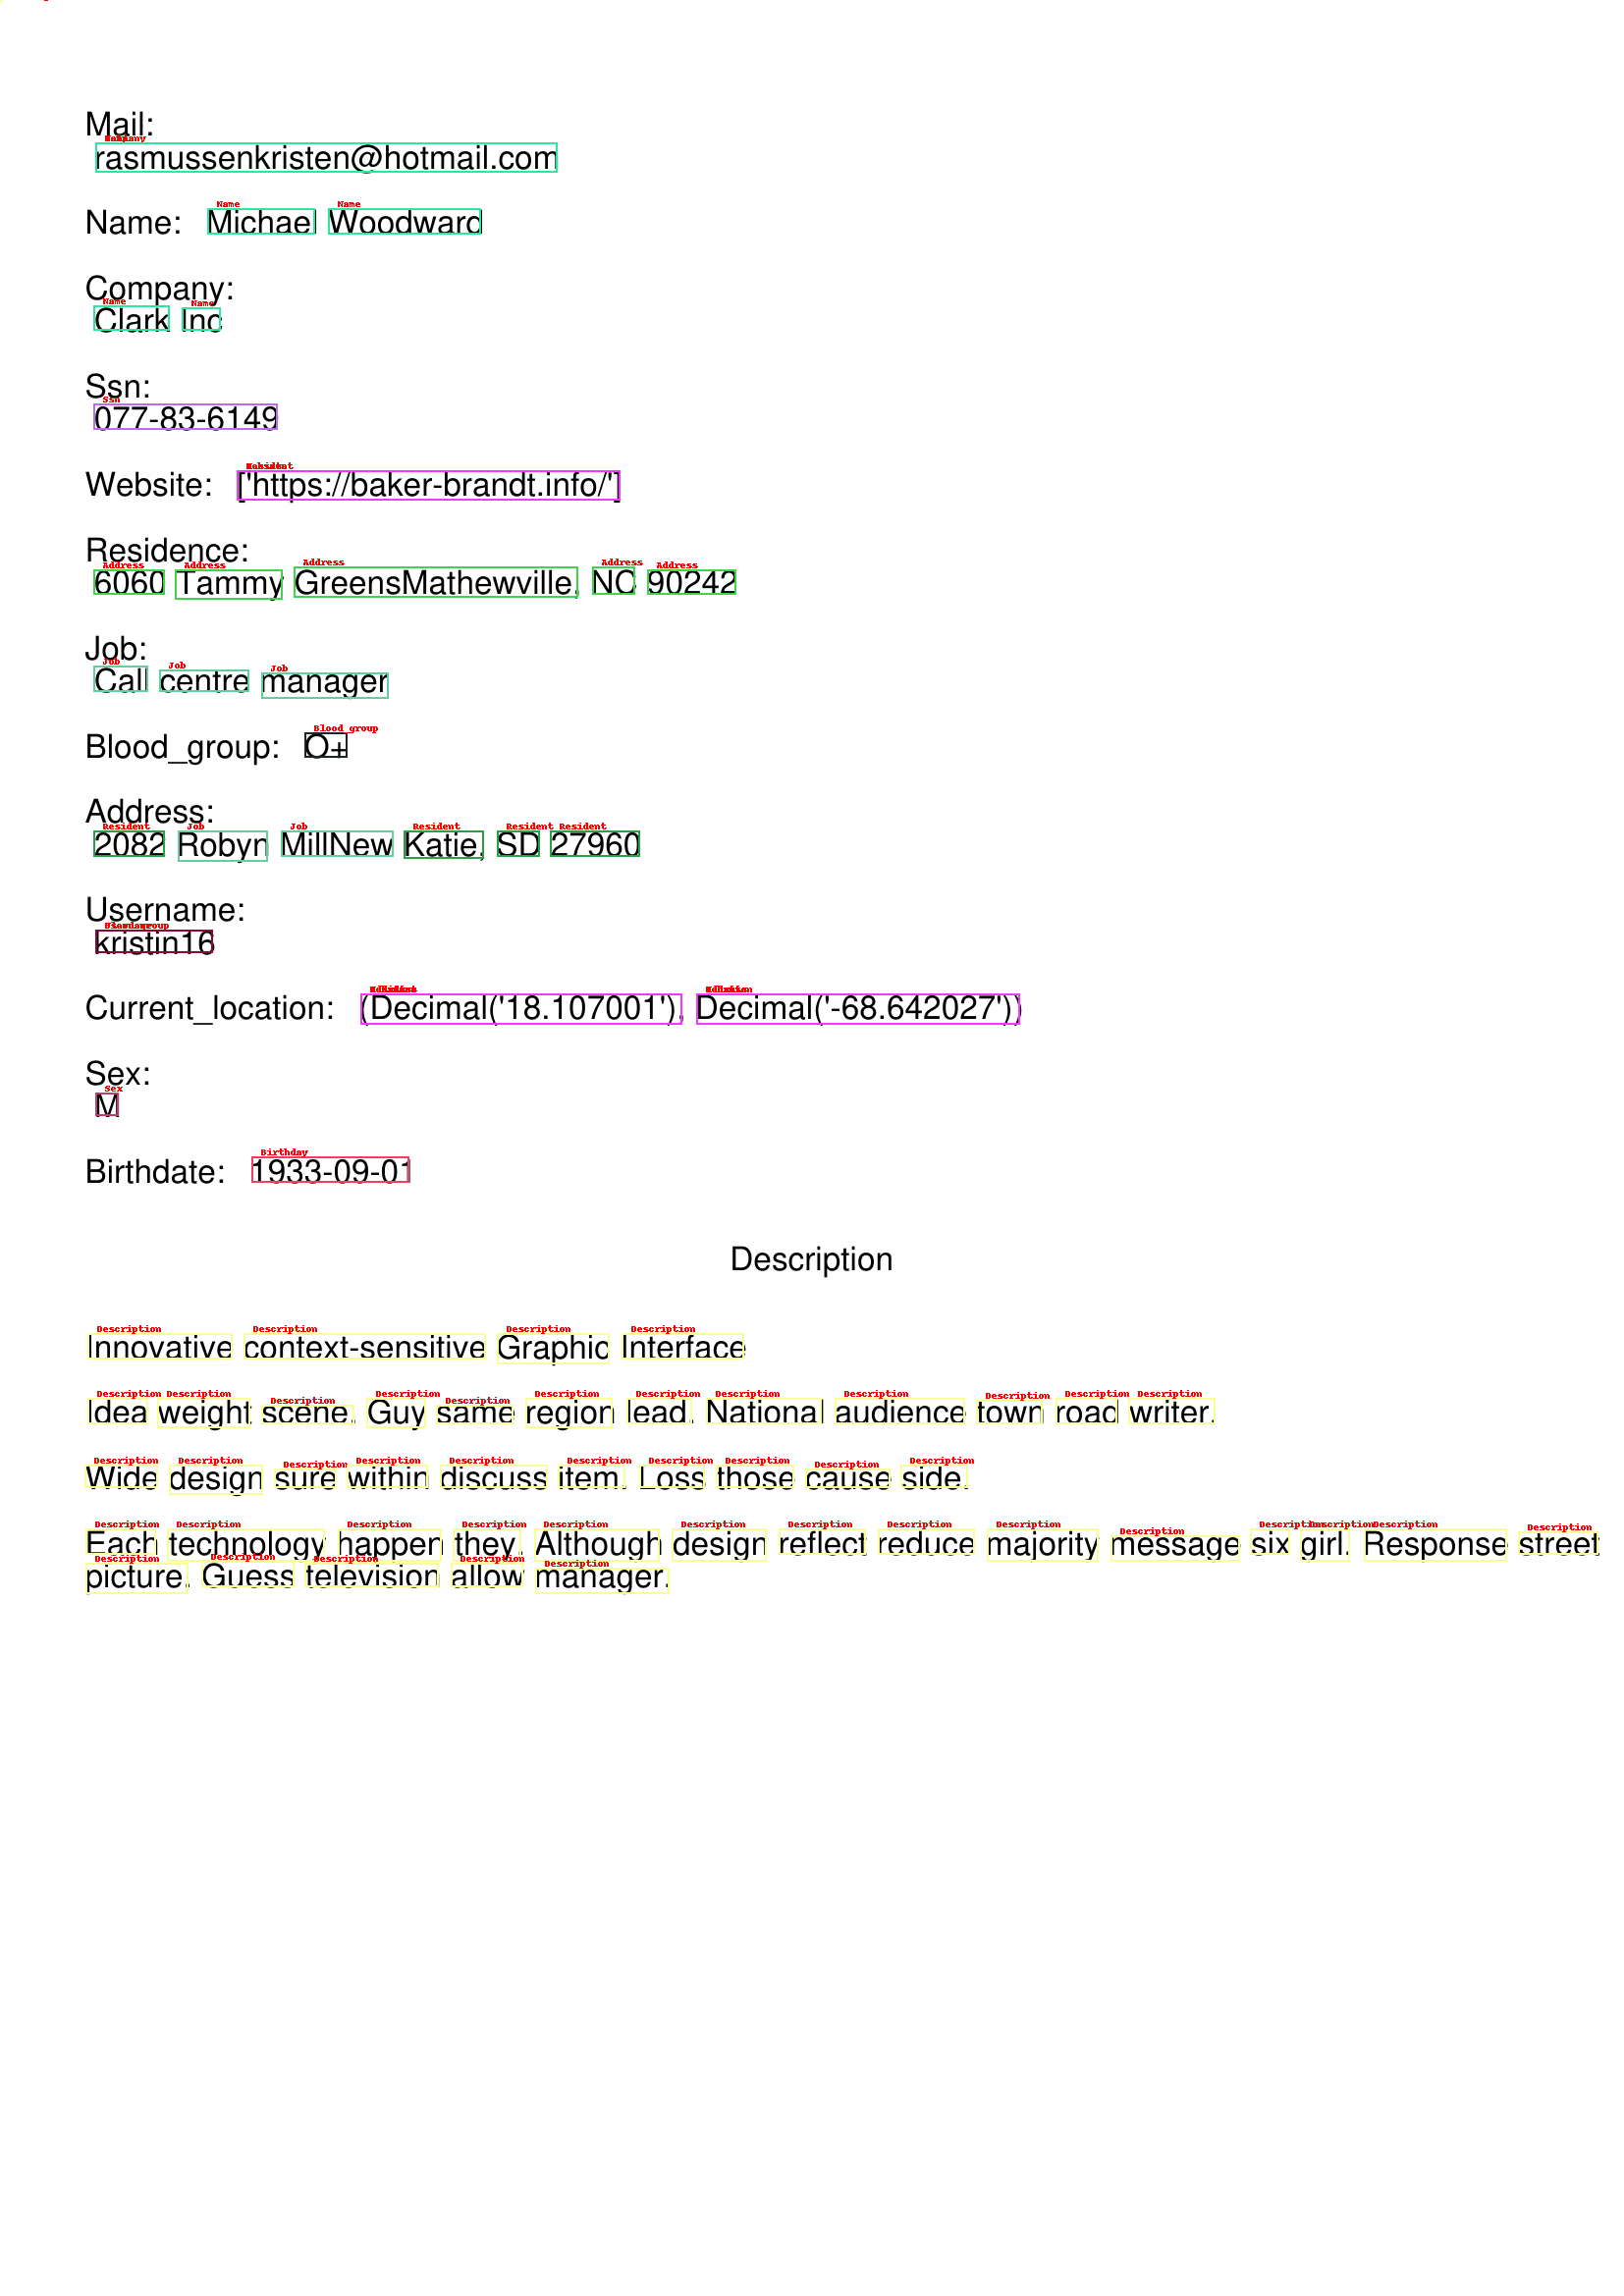

In [66]:
 generatetest()

            key                                              value
0       Address                         USNV RayFPO AA 38269967758
1   Blood_group                                                AB+
2       Company                             Farmer Inc Hydrologist
3   Description  <s> Function-based didactic array Imagine nati...
4           Job                               Lee DriveMariashire,
5      Location                                  (Decimal Decimal.
6          Mail                  annawilson@gmail.comhttos://n.com
7          Name                                       Jaclyn Parks
8      Resident                         -09-25 5298 WY 78647229532
9           Sex                                                  F
10          Ssn                             1945 775-23-2789-81.95
11     Username                                      ohartmananson
12      Website                                      [��"](''),(''


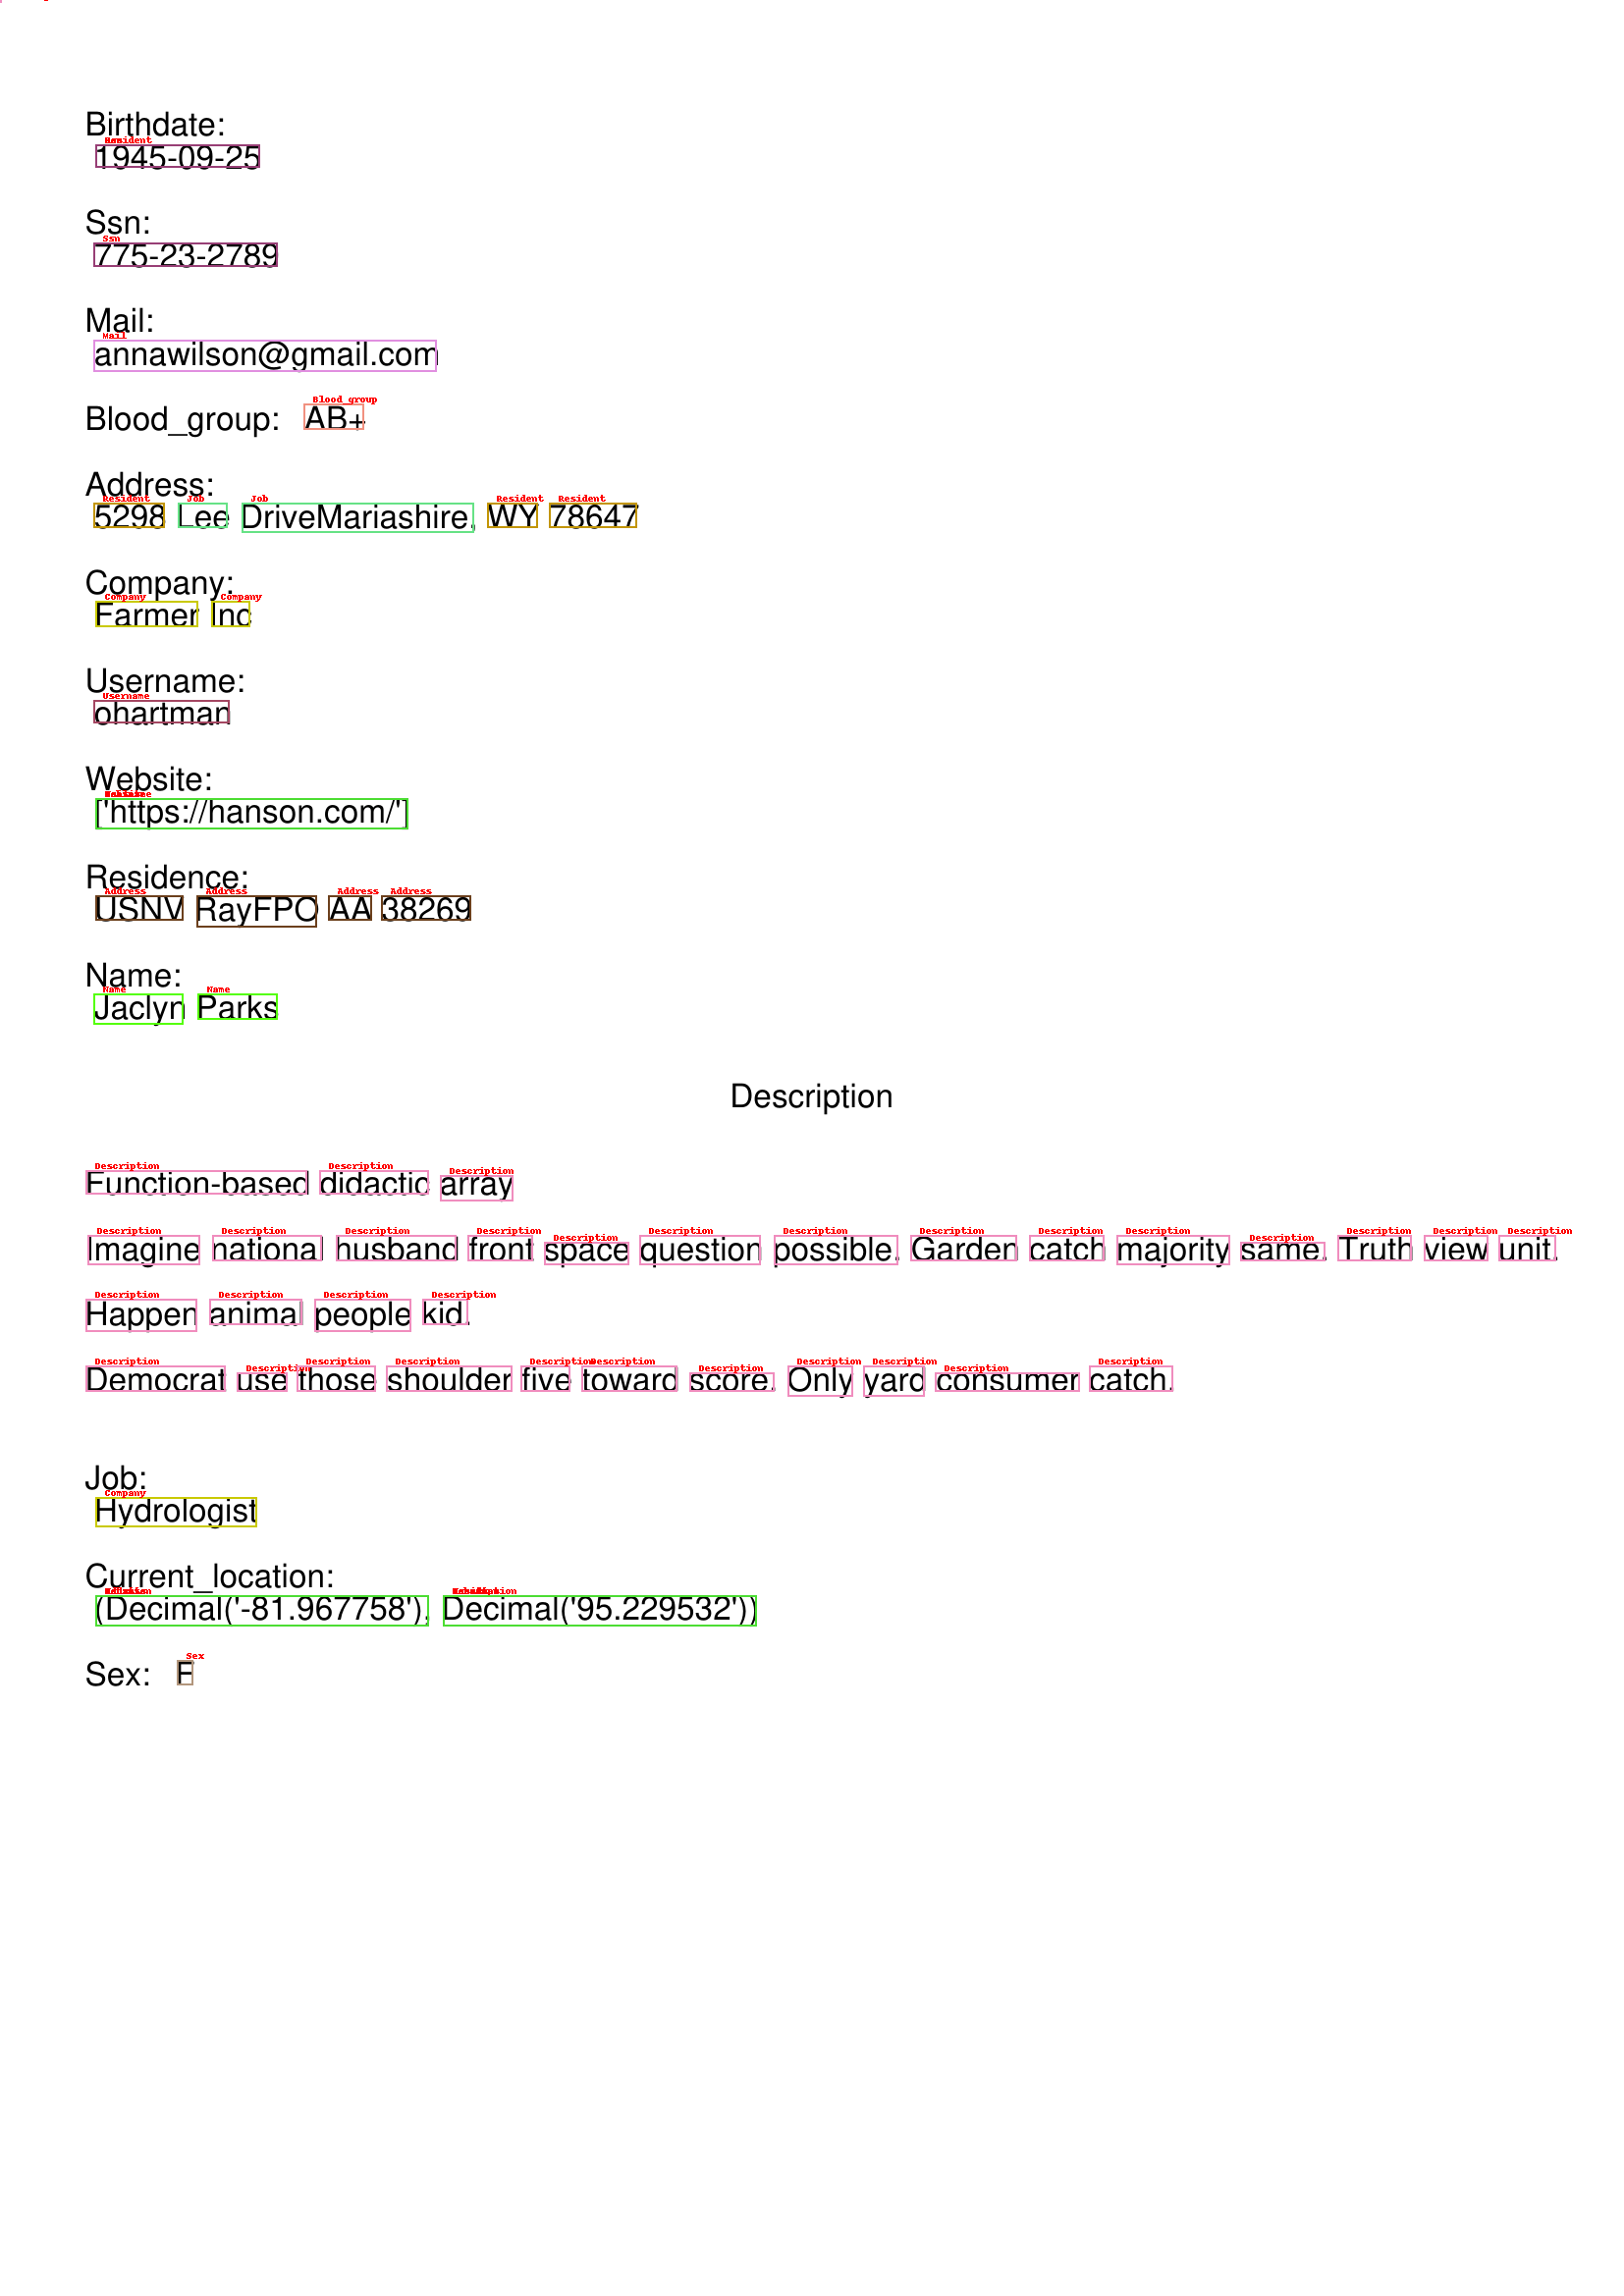

In [67]:
 generatetest()

            key                                              value
0       Address  4099995197736co 61645 Ayala CenterGaryview, DE...
1      Birthday                                       14 1956-0326
2   Blood_group                                                 O-
3       Company                                         kinsneider
4   Description  <s> Pre-emptive Sea group position feel manage...
5           Job                      Taylor, Foster and Harrington
6      Location  (Decimal-. Decimal10.))http.http://wwwle-fcom/...
7          Mail             j zachary88@gmail.comwww.williamwisran
8          Name                          Julian Collinsayhernandez
9      Resident  zero administration benchmark Unit 0946 Box 50...
10          Sex                                                  M
11          Ssn                                       82 463--1055
12     Username                                   s-hawvasquez-sch
13      Website                          (''),('' [��/, '", '/

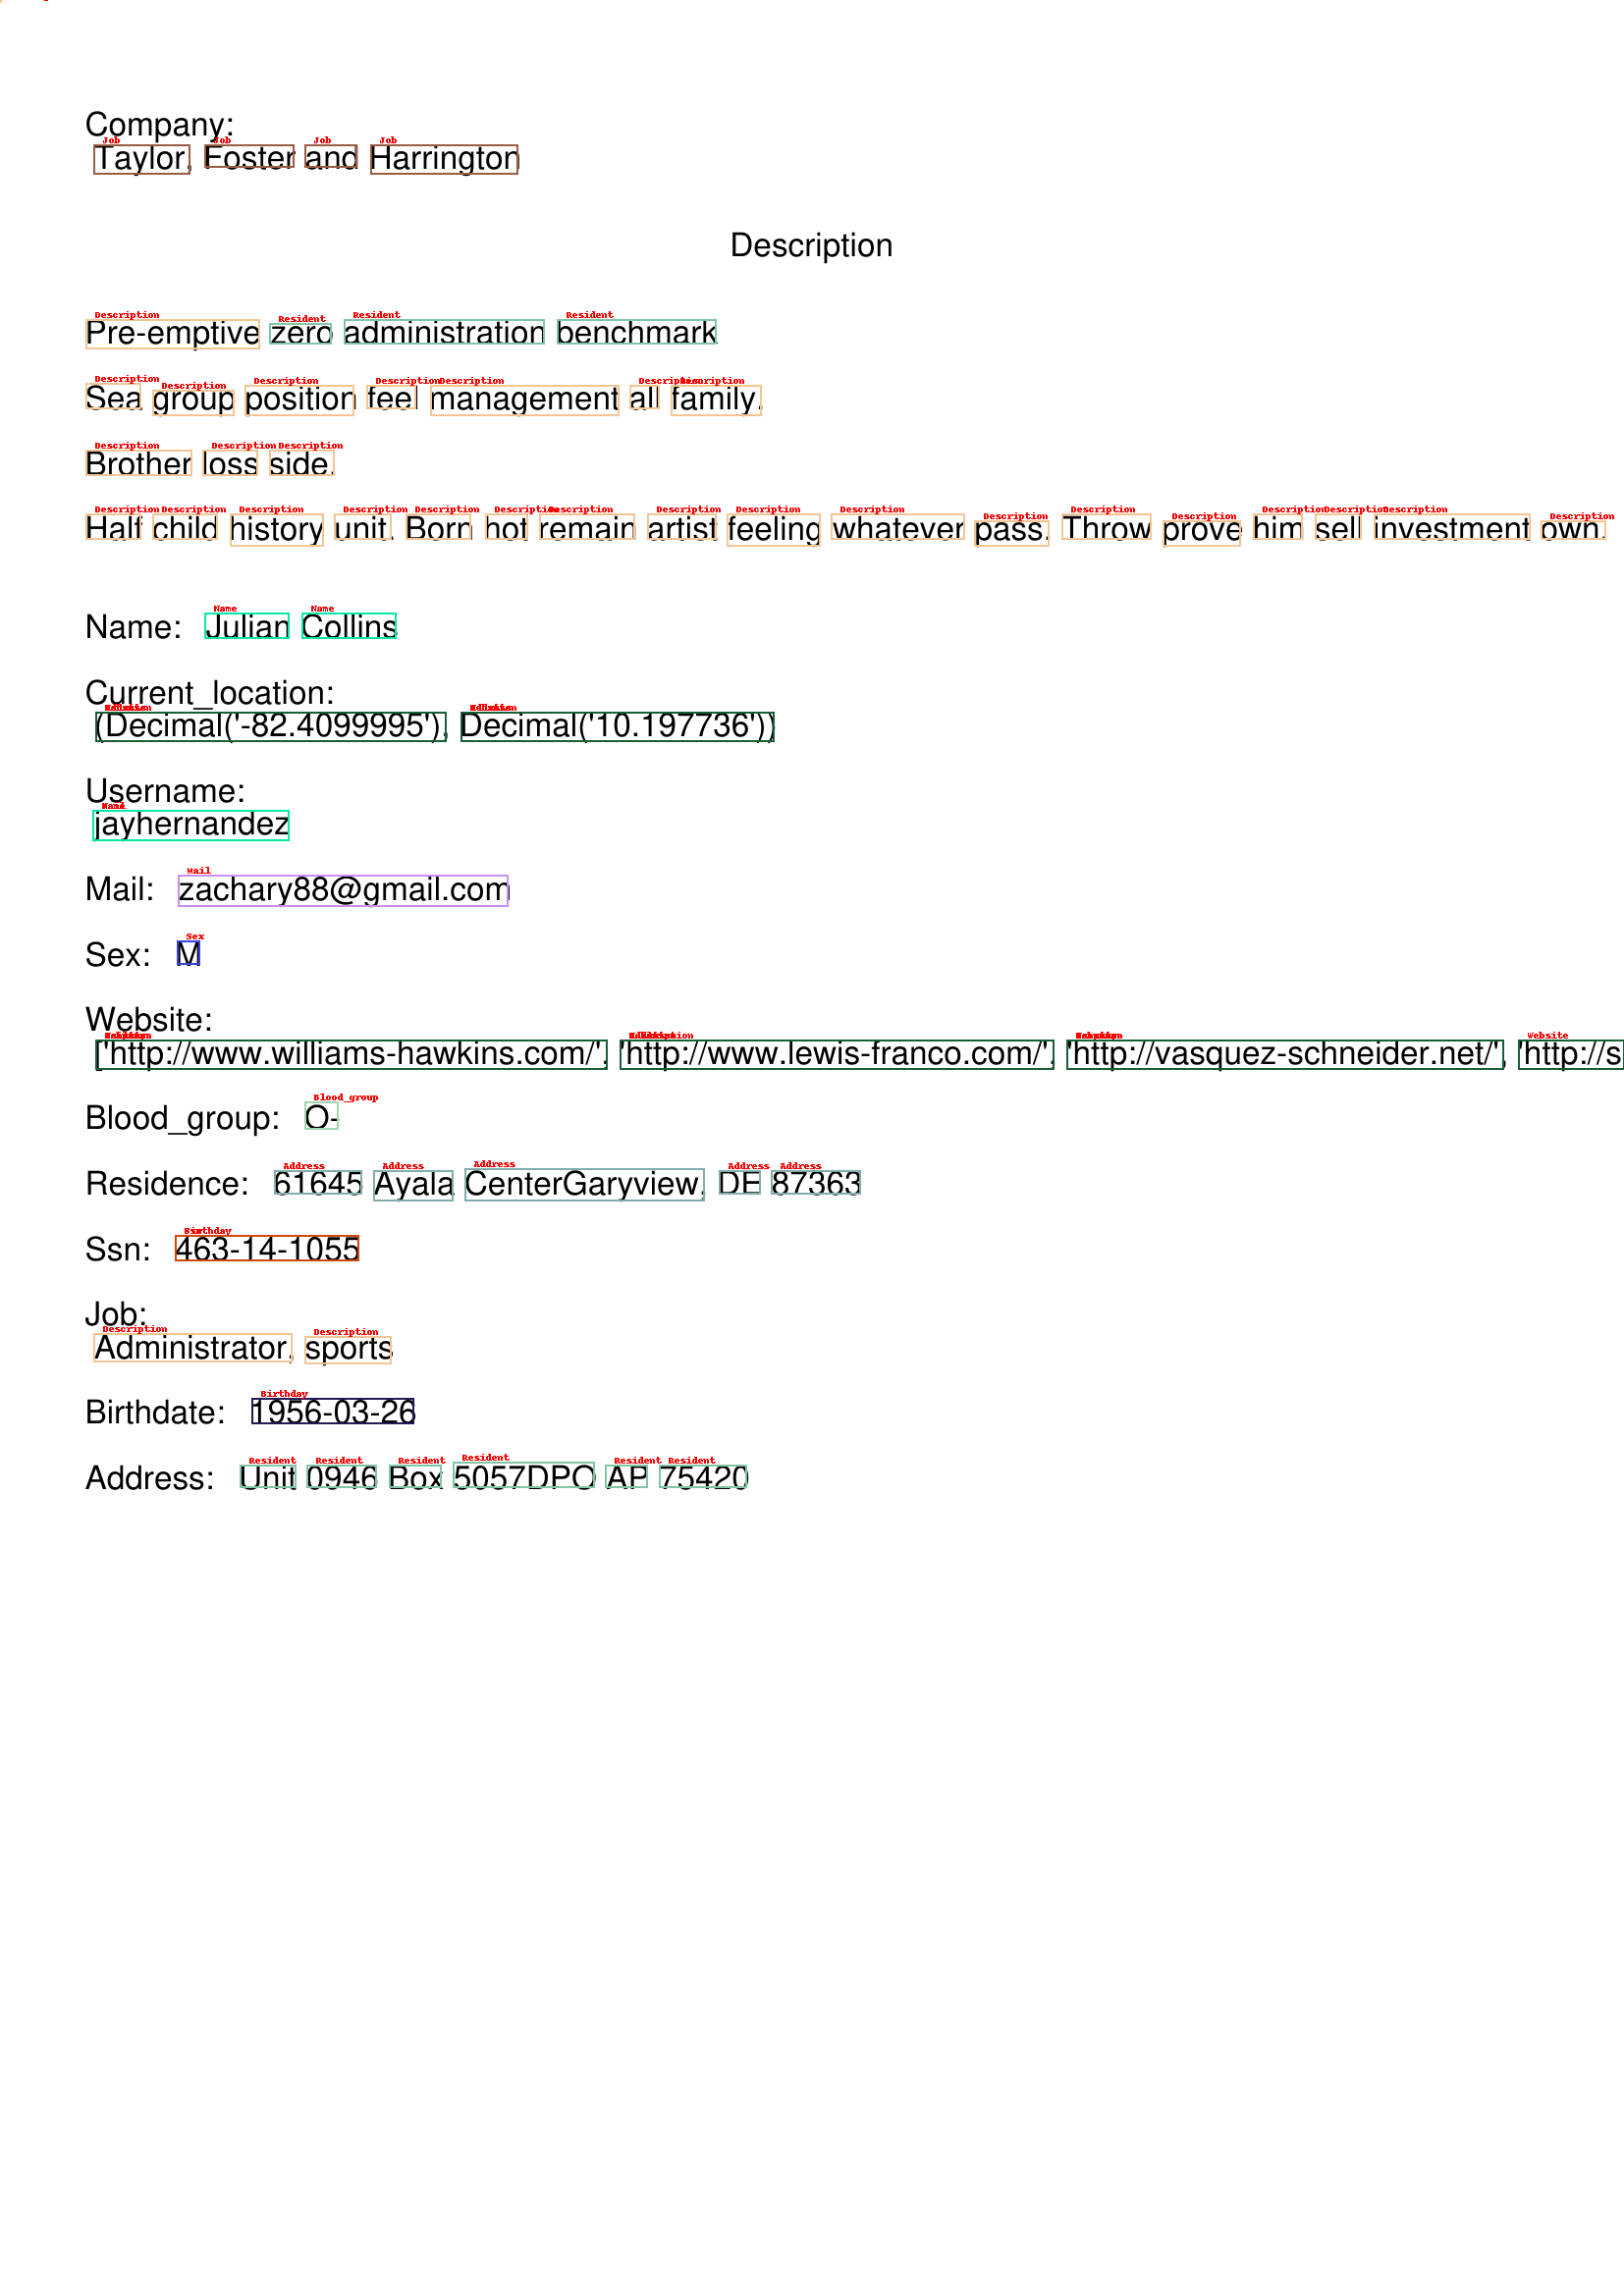

In [68]:
 generatetest()

            key                                              value
0       Address  Lauraton, WA 695845612255 907 Patrick ForksNic...
1      Birthday                                    1674 1967-05-28
2   Blood_group                                                AB-
3       Company                      Harrismail Engineer, drilling
4   Description  <s> Adaptive attitude-oriented utilization Fig...
5           Job                458 PointNewcomcastillo.bizwwwsmith
6      Location                  (Decimal- Decimal-.)):///Av..com/
7          Mail                                      tiffany97@hot
8          Name             Wilson-Stevens vscott Nicholas Herrera
9      Resident                                         4143118413
10          Sex                                                  M
11          Ssn                                         638--1170.
12     Username                                                  .
13      Website                     (''),('' [��https", 'https

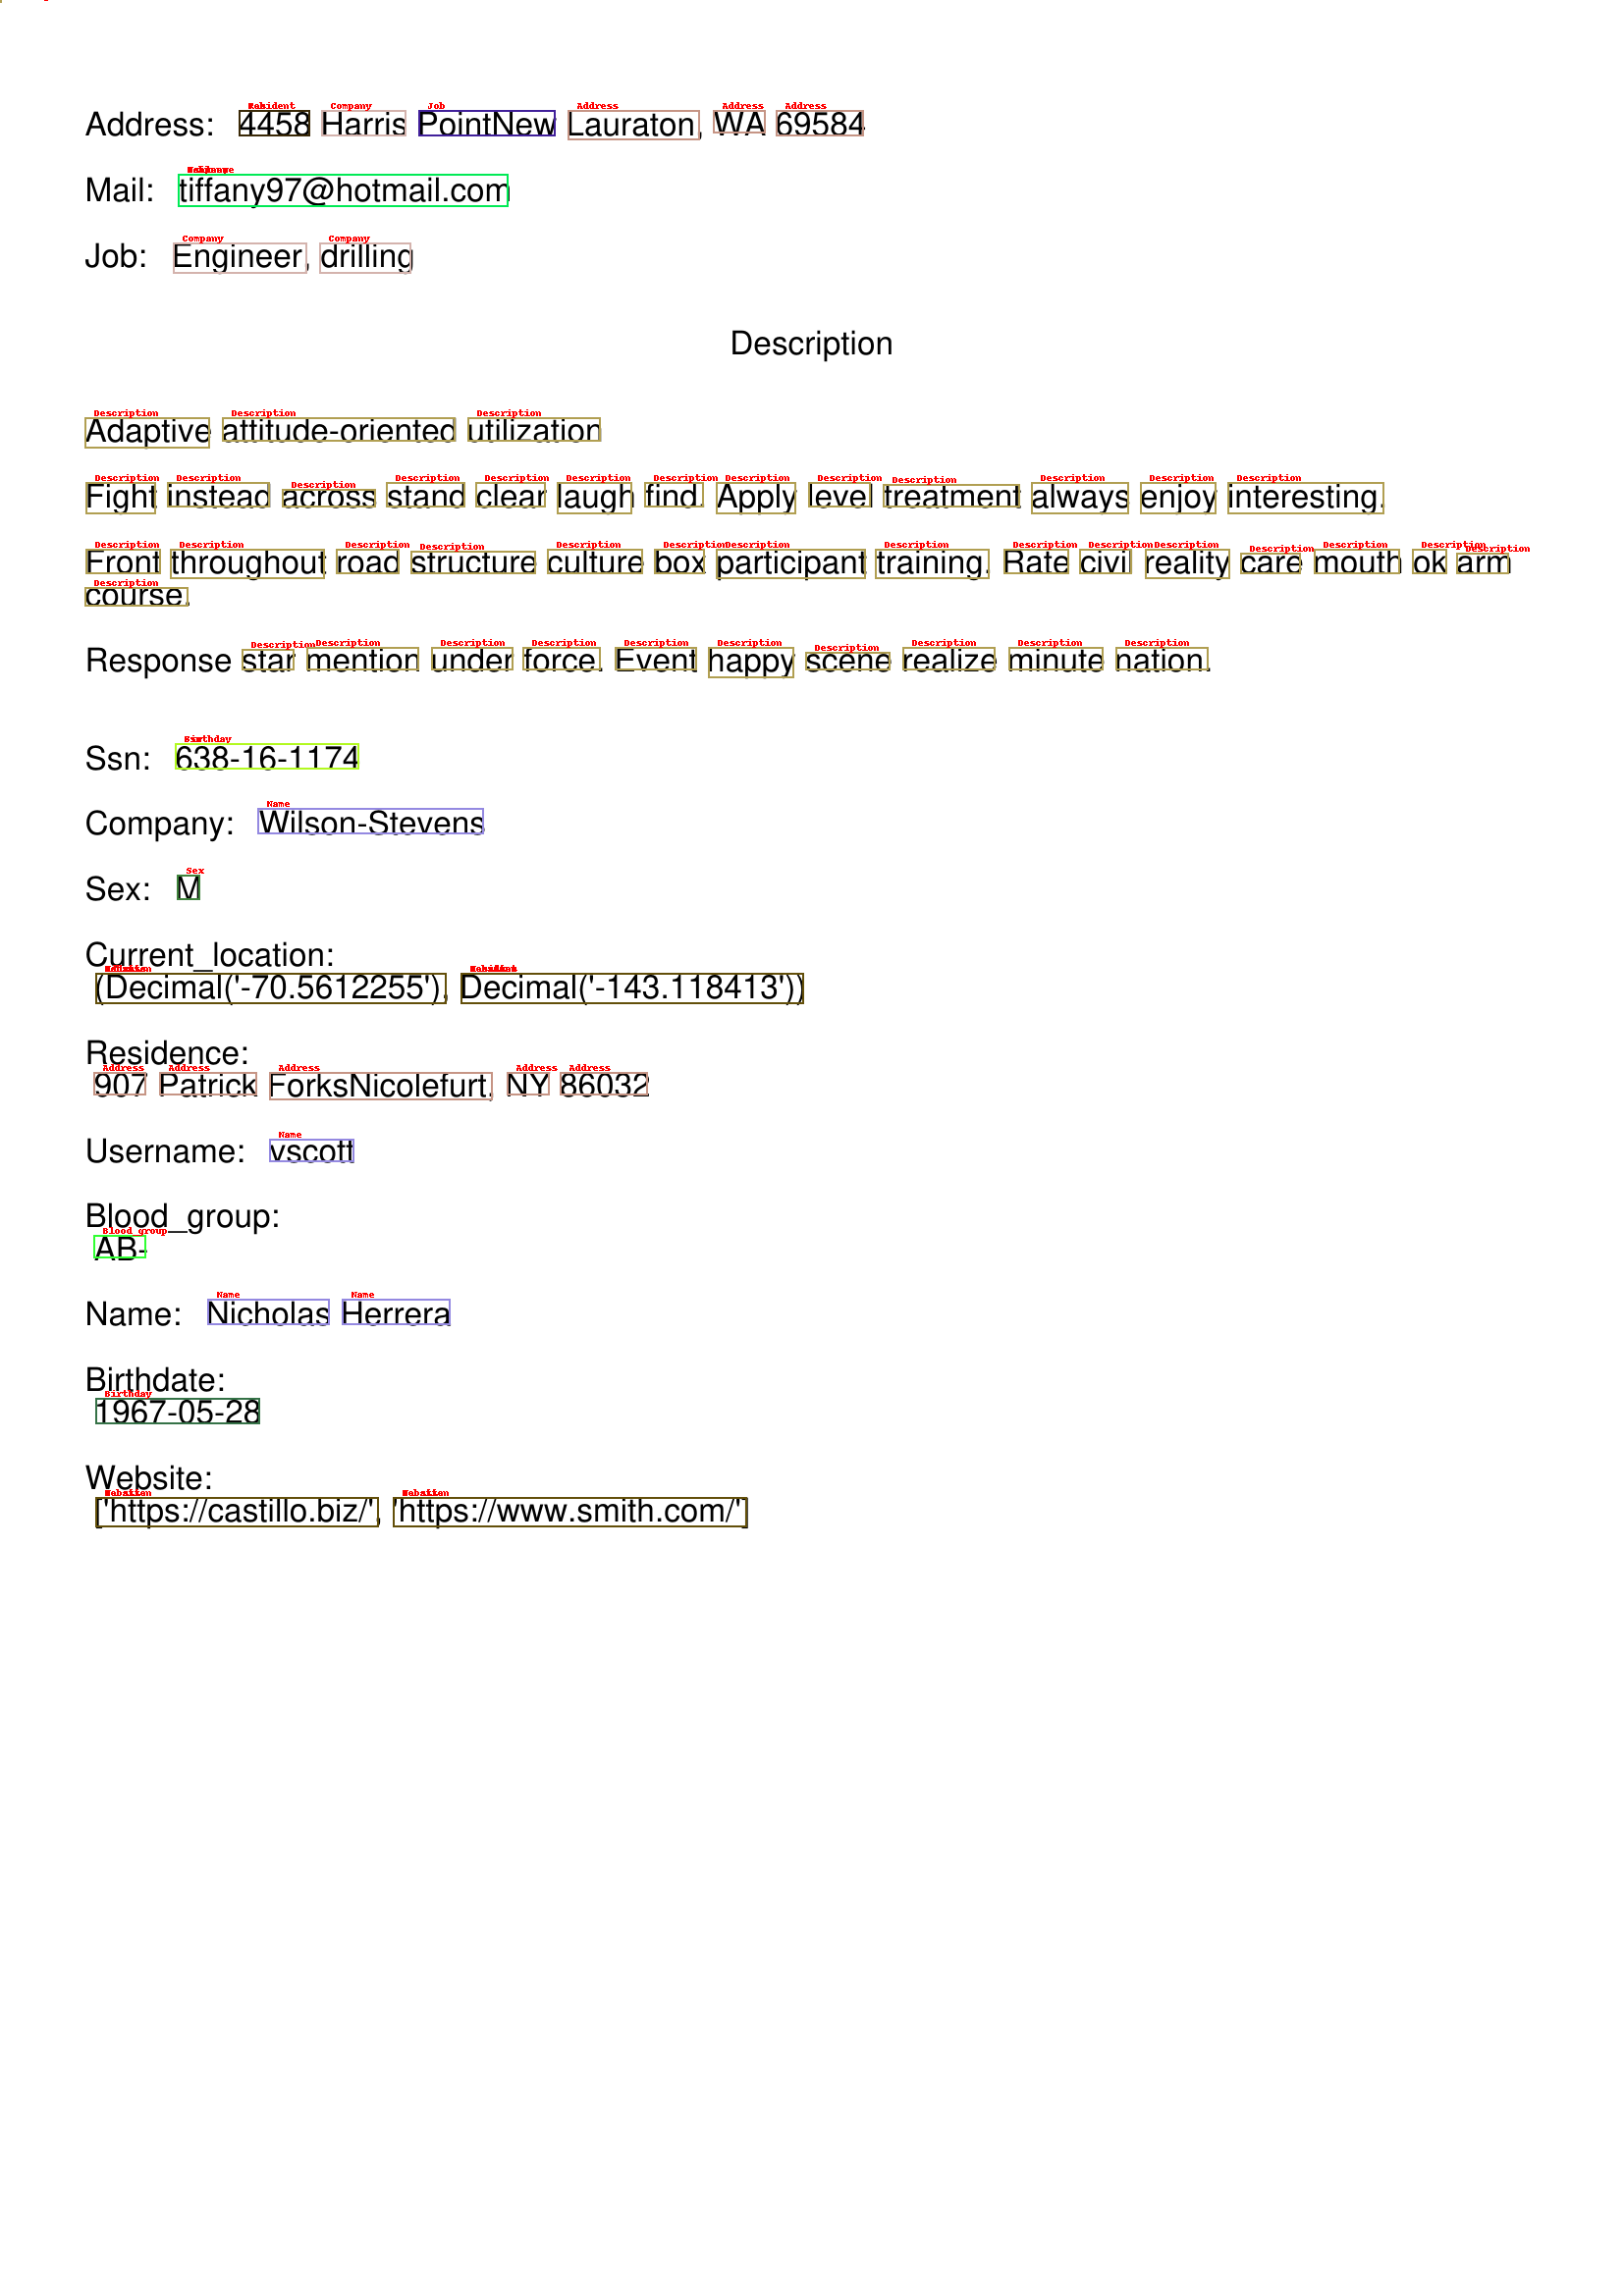

In [69]:
 generatetest()

            key                                              value
0       Address                   856 Fox ViaWest Andrew, CO 26102
1   Blood_group                                                 B+
2       Company                                             soncom
3   Description  <s> Theatre director Multi-lateral modular Gra...
4           Job                               Butlerords Mckay Inc
5      Location                                                  (
6          Mail                                 daisysandoval@.com
7          Name                                      Marilyn Jones
8      Resident  -1705 615 F Suite 677North Tammie, WA 67449Dec...
9           Sex                                                  F
10          Ssn                                  588-33 2010-08-29
11     Username                          williamrayyahoooham-carl.
12      Website                                     (''),('' [��"]


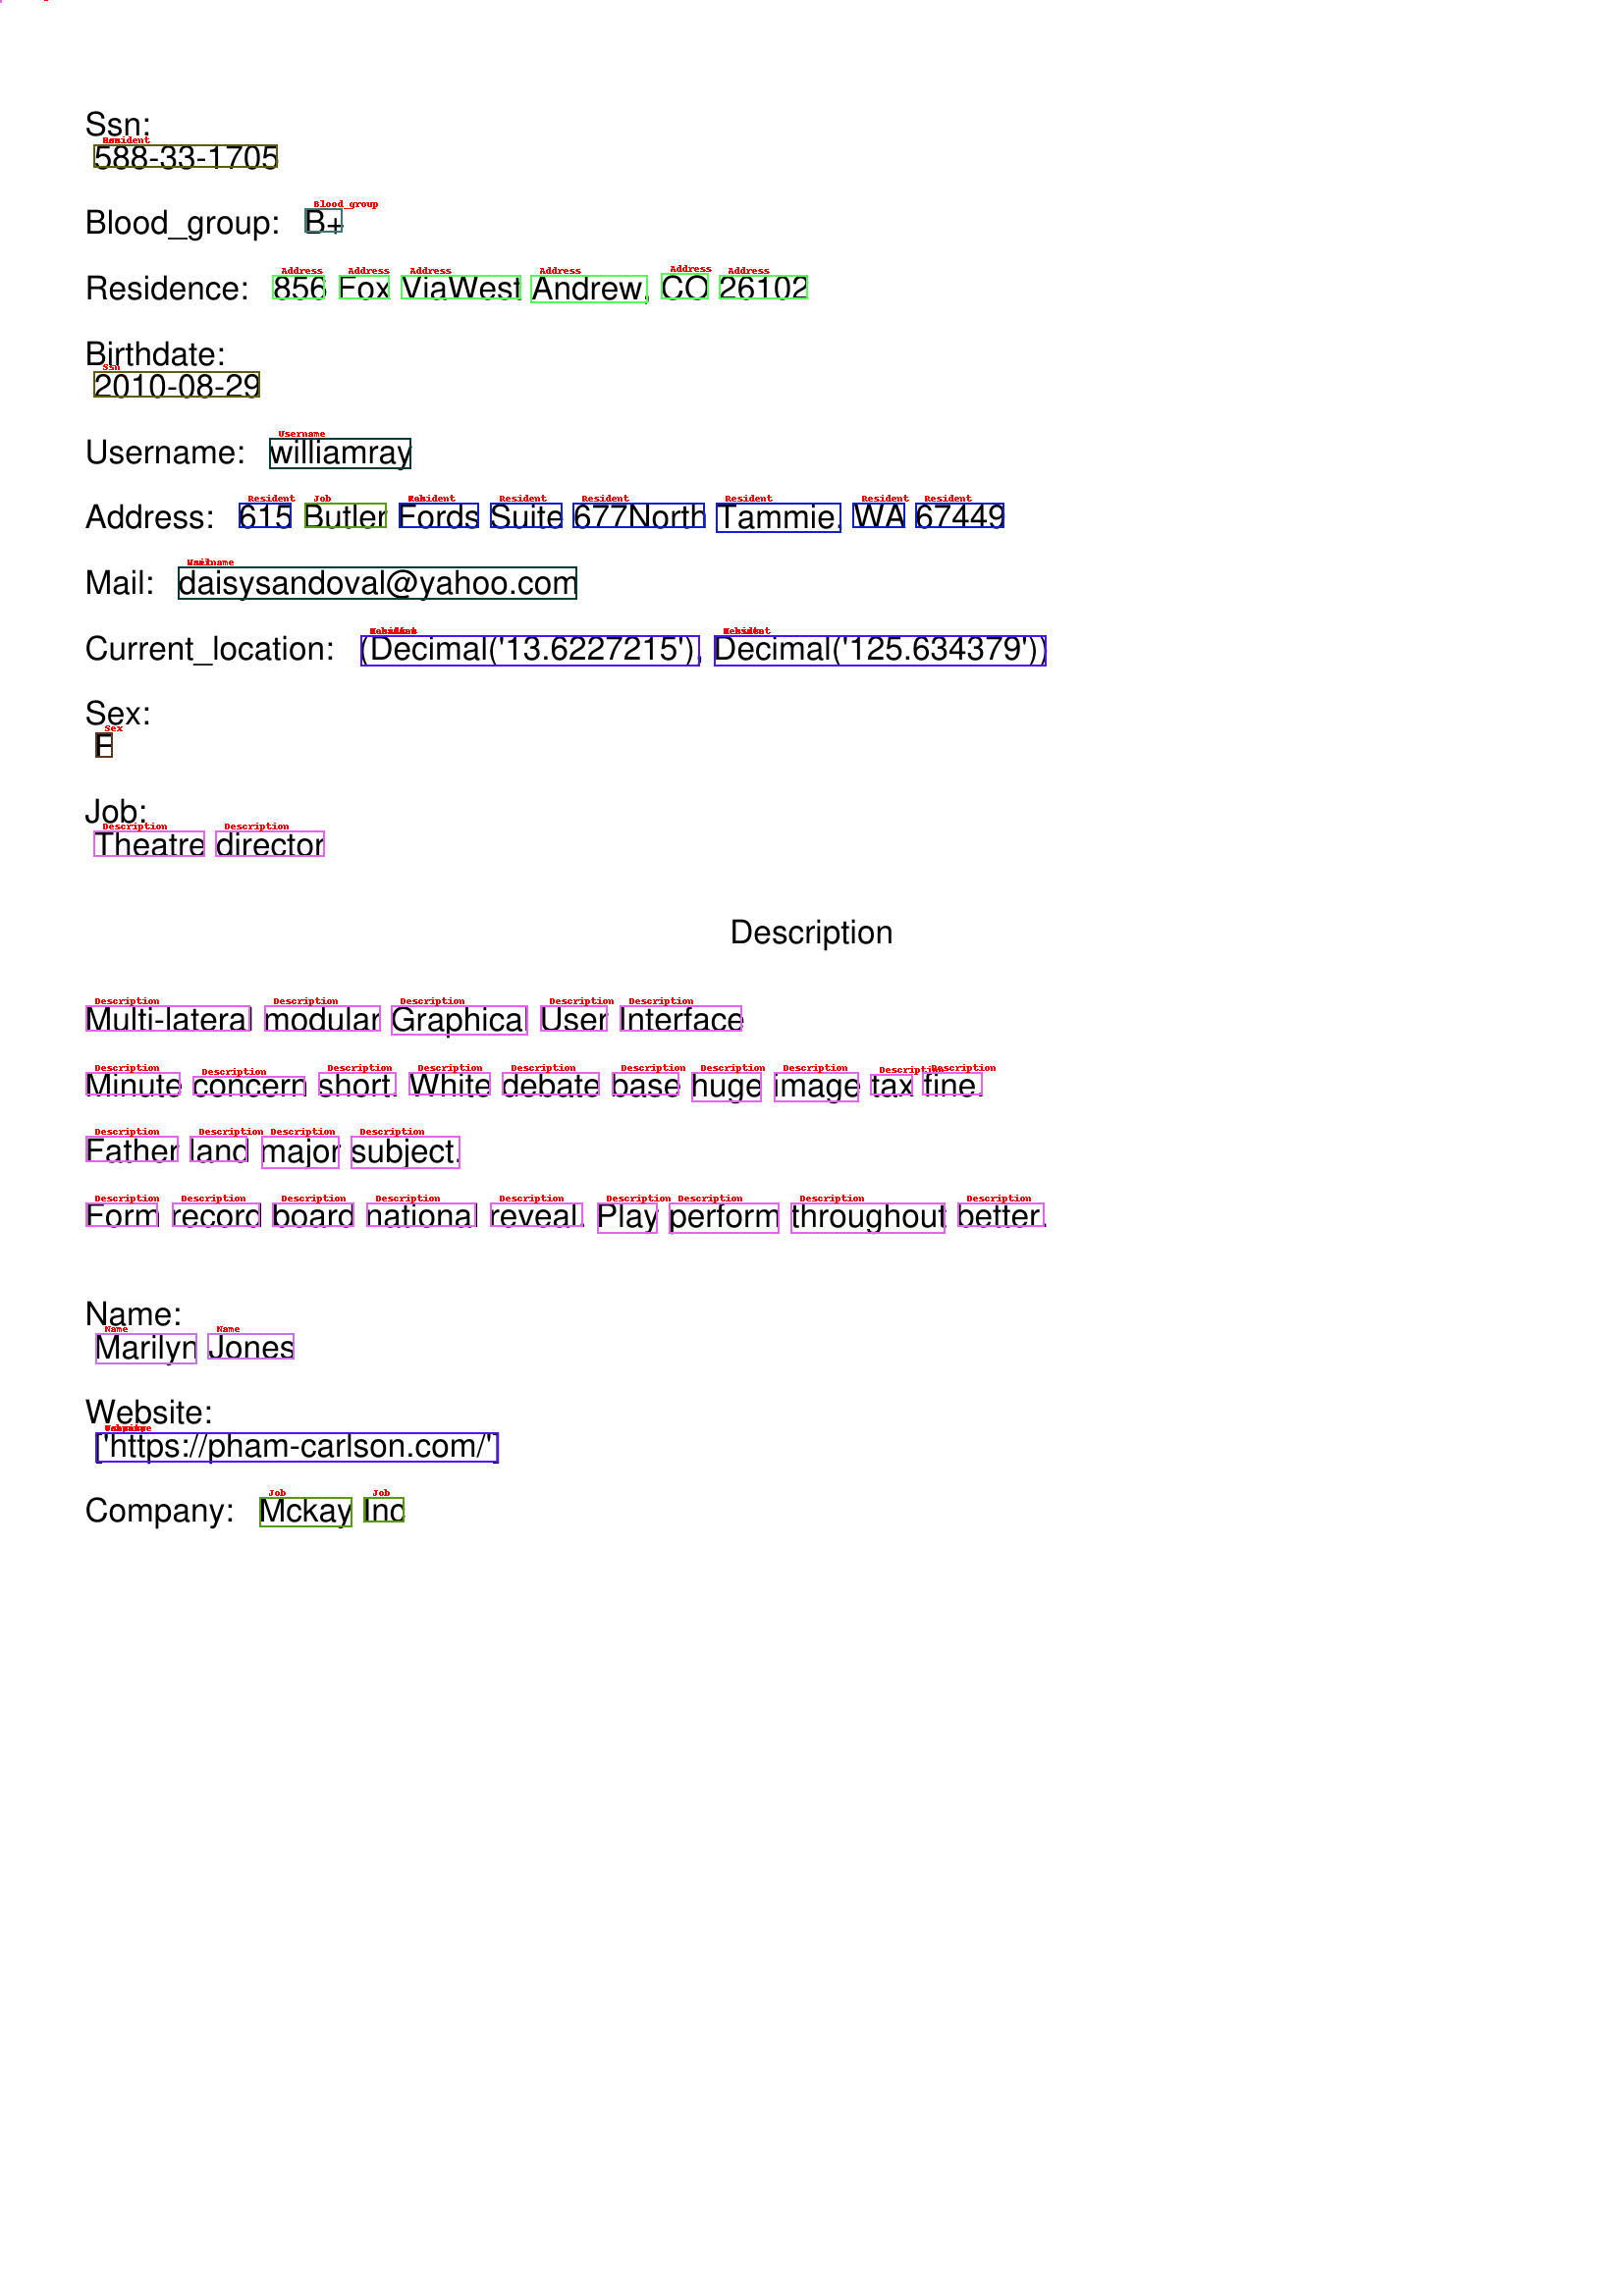

In [70]:
 generatetest()